### IMPORTS

In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
angle = []

### TO DISPLAY THE IMAGES

In [2]:
def display(what, *imgs):
    while True:
        for i,img in enumerate(imgs):
            cv2.imshow('image'+str(i)+"-------"+str(what), img)
        if cv2.waitKey(1):
            break

    # cv2.destroyAllWindows()

### TO DRAW ON IMAGES

In [3]:
def draw(img, *finals):
    road = np.zeros([img.shape[0], img.shape[1]], np.uint8)
    for final in finals:
        for point1, point2 in zip(final, final[1:]):
            cv2.line(img, point1, point2, (0,0,255), 3)
            cv2.line(road, point1, point2, (255,255,255), 3)
    # display(img, road)
    return road

### REMOVE THE EXTRA POINTS DETECTED ON THE SAME CONE

In [4]:
def removeClsPt(new_lst):

    X = [x for (x,y) in new_lst]
    
    pts_dict = dict(new_lst) # converting the points list into dictionary

    # collecting the points whose x axis is close by ie < 15 pixels
    closeX_pts = [
        (X[i], X[i + 1])
        for i, _ in enumerate(X)
        if i != len(X) - 1 and X[i + 1] - X[i] <= 15
    ]


    closeX_pts = list({item for t in closeX_pts for item in t}) # converting dict to list
    # print(closeX_pts)

    if not closeX_pts:
        return new_lst

    newY = int(np.mean([pts_dict[i] for i in closeX_pts])) # getting mean of y points from the closest x points
    newX = int(np.mean(closeX_pts)) # getting mean of x points
    for pts in closeX_pts:
        pts_dict.pop(pts) # removing the points from the main dictionary
    pts_dict.update({newX : newY}) # adding the new point into the dictionary

    return [(k,v) for (k,v) in sorted(pts_dict.items())]
    

### TO SEPARATE THE ROADS

In [5]:
def separateRoad(new_lst):
    X = [x for (x,y) in new_lst] # getting x points from the detected points

    for i, _ in enumerate(X):
        if i != len(X) - 1 and X[i + 1] - X[i] > 275: # splitting the lines if pixel difference is > 300 pixels
            break

    road0 = removeClsPt(new_lst[0:i+1]) # making 2 separate list for 2 sides of roads
    road1 = removeClsPt(new_lst[i+1:])

    return road0, road1

### TO FIND THE BIRD EYE VIEW OF THE ROADS LANES DETECTED

In [6]:
def bird_view(road0, road1, img):
    if road0 and not road1:
        road1.append([img.shape[0], road0[-1][1]])
        road1.append([img.shape[0], road0[0][1]])

    if road1 and not road0:
        road0.append([0, road1[-1][1]])
        road0.append([0, road1[0][1]])

    # the bottom left and bottom right are 1st point of leftRoad and last point of rightRoad respectively
    # the top left point's x-axis from leftRoad 1st points x-axis and y-axis from leftRoad last point y-axis
    # the top right point's x-axis from rightRoad last points x-axis and y-axis from rightRoad 1st point y-axis
    pts1 = np.float32([ [road0[0][0], road0[-1][1]-100], [road1[-1][0], road1[0][1]-100], [road0[0][0], road0[0][1]+100], [road1[-1][0], road1[-1][1]+100] ]) # top-left, top-right, bottom-left, bottom-right ------> (x,y)
                        
    pts2 = np.float32([[50, 0], [350, 0], [50, 350], [350, 350]]) # projection window size

    # changing perspective to get the bird-eye view
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    inv_matrix = cv2.getPerspectiveTransform(pts2, pts1)
    return cv2.warpPerspective(img, matrix, (400,400))

### TO DRAW THE EDGES ON THE LINE DETECTED AND FIND THE ANGLE OF IT FROM X-AXIS

In [7]:
def line_and_angle(result):
    blank_img = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    big = 0

    hough = cv2.HoughLinesP(result, rho=6, theta=np.pi/180, threshold=127, lines=np.array([]), minLineLength=50, maxLineGap=5)
    for line in hough:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_img, (x1,y1), (x2,y2), (0,255,0), 1)
            big = max(big, abs((y2 - y1)/(x2 - x1)))
            # print((x1,y1), (x2, y2))


    ang = math.atan(big)
    angle.append(ang)
    if ang < 0.7:
        return 0
    else:
        return 1
    

### CONE DETECTION

In [8]:
def detect(frame_img):
    # Reading the image
    img = cv2.resize(frame_img, (0,0), fx = 0.5, fy = 0.5)
    # img = cv2.imread("road2_edited.jpg")

    # Converting the image to hsv image for better thresholdinghr
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Thresholding the image using BINARY THRESHOLD 
    ret, thresh = cv2.threshold(hsv_img, 190, 225, cv2.THRESH_BINARY)

    # Converting the thresholded image to an grayscale
    image = cv2.cvtColor(thresh, cv2.COLOR_HSV2BGR)
    image = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)


    # Applying Morphological operators for smoothing out the image
    kernal = np.ones((2,2), dtype=np.uint8)
    grad = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernal, iterations=2)
    ret, grad = cv2.threshold(grad, 190, 255, cv2.THRESH_TOZERO)



    # APPLYING WATERSHED ALGORITHM
    dist_transform = cv2.distanceTransform(grad, cv2.DIST_L2, 3)

    ret, sure = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)

    grad2 = cv2.morphologyEx(sure, cv2.MORPH_OPEN, kernal, iterations=1)

    grad3 = cv2.dilate(grad2, kernal, iterations=3)

    grad3 = np.uint8(grad3)

    ret, markers = cv2.connectedComponents(grad3)

    _, contours, heirarchy = cv2.findContours(grad3, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # By the contours detected drawing bounding boxes and finding the centriod point which is used to draw a path line
    im = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    lst = []
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
        centroid = tuple( [x+(w//2), y+(h//2)] )
        lst.append(centroid)
        cv2.circle(im, centroid, 5, (255,0,0), -1)
    new_lst = sorted(lst)
    # draw(im, new_lst)

    road0, road1 = separateRoad(new_lst);
    # road = draw(img, road0, road1)
    result = (bird_view(road0, road1, draw(img, road0, road1)));
    ang = line_and_angle(result);
    display(ang, img);

    return img

    

In [9]:
# detect(cv2.imread("test0.jpg"))

In [10]:
cap = cv2.VideoCapture("Track.mp4")

width = int(cap.get((cv2.CAP_PROP_FRAME_WIDTH)))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer = cv2.VideoWriter('lets_see_magic.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20.0, (width, height))

if cap.isOpened == False:
    print("Error!! \n File not found or wrong CODEC used")

while cap.isOpened:
    ret, frame = cap.read()
    if ret != True:
        break

    try:
        writer.write(detect(frame))
    except:
        pass

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()
writer.release()

In [11]:
with open("angle.txt", "w") as f:
    for i,val in enumerate(angle):
        f.write(str(i) + "," + str(val) + "\n")

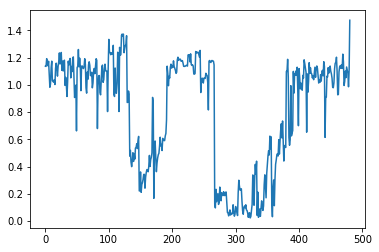

In [14]:
plt.plot(angle)

In [12]:
len(angle)

481

In [13]:
print("curve roads: ", len([x for x in angle if x<0.7]))
print("straight roads: ", len([x for x in angle if x>=0.7]))
print("Total number of frames where cones are detected is:", len(angle))

curve roads:  177
straight roads:  304
Total number of frames where cones are detected is: 481


In [25]:
cap = cv2.VideoCapture("Track.mp4")


if cap.isOpened == False:
    print("Error!! \n File not found or wrong CODEC used")

while cap.isOpened:
    ret, frame = cap.read()

    if ret != True:
        break

    try:
        detect(frame)
    except:
        pass

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()

In [28]:
cap = cv2.VideoCapture("Track.mp4")


if cap.isOpened == False:
    print("Error!! \n File not found or wrong CODEC used")

while cap.isOpened:
    ret, frame = cap.read()

    if ret != True:
        break

    cv2.imshow("video", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()